In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, LineString, Point
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import normaltest
import warnings
from sklearn.metrics import silhouette_score
warnings.filterwarnings("ignore")

In [2]:
def plot_sidebysides(t_df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
    sn.countplot(x = '{}'.format(col), data = t_df.query('num_lf == 0'), ax = ax1,\
                 order = t_df['{}'.format(col)].value_counts().index).set(title = 'No Liofish')
    sn.countplot(x = '{}'.format(col), data = t_df.query('num_lf > 0'), ax = ax2,\
                 order = t_df['{}'.format(col)].value_counts().index).set(title = 'Lionfish');

In [3]:
lf_df = pd.read_csv('../data/processed/lion_fish.csv')
df = pd.read_csv('../data/processed/combined_df.csv')
gdf = gpd.read_file("../data/processed/with_land_df.shp")

In [4]:
lf_df.head()

,Latitude,Longitude,Accuracy,Drainage Name,Year,Month,Day,lat_lon
0,18.433820,-64.444990,Accurate,Eastern Caribbean,2022,2.0,27.0,"(-64.44499, 18.43382)"
1,18.051071,-67.908004,Accurate,Greater Antilles,2010,1.0,10.0,"(-67.908004, 18.051071)"
2,18.112100,-67.934000,Accurate,Greater Antilles,2009,4.0,5.0,"(-67.934, 18.1121)"
3,17.938900,-67.023100,Approximate,Greater Antilles,2009,5.0,15.0,"(-67.0231, 17.9389)"
4,17.965800,-66.761600,Accurate,Greater Antilles,2010,6.0,6.0,"(-66.7616, 17.9658)"


In [5]:
df.head()

,AREA,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,num_lf
0,6445.33,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,0
1,47409.30,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,0
2,44504.30,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,0
3,5698.10,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_4,0
4,24547.68,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,STJ_5,0


In [6]:
gdf.head(3)

,AREA,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry
0,6445.33,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366..."
1,47409.30,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359..."
2,44504.30,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356..."


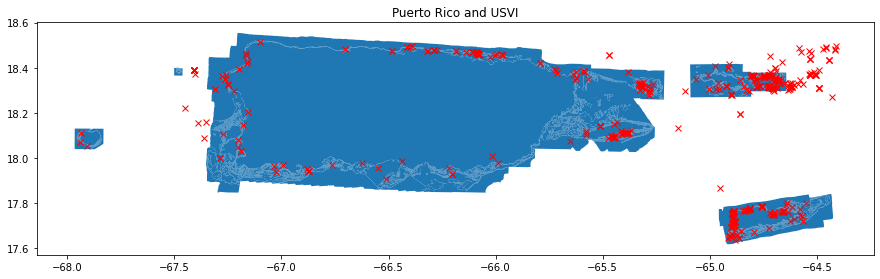

In [7]:
#some LF are on land and some outside the benthic mapping, they are not included in df
fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(lf_df.Longitude, lf_df.Latitude, marker = 'x', color = 'r', linestyle = 'None')
plt.title('Puerto Rico and USVI')
gdf.plot(categorical=True, figsize=(10,10), markersize=45, ax=ax);

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AREA        7384 non-null   float64
 1   DESCRIPTOR  7384 non-null   object 
 2   ZONE        7384 non-null   object 
 3   HABITAT     7384 non-null   object 
 4   TYPE        7384 non-null   object 
 5   polyid      7384 non-null   object 
 6   num_lf      7384 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 403.9+ KB


In [9]:
df.describe()

,AREA,num_lf
count,7.384000e+03,7384.000000
mean,2.823915e+05,0.042118
std,2.033447e+06,0.313129
min,5.905000e+01,0.000000
25%,1.147043e+04,0.000000
50%,3.116726e+04,0.000000
75%,1.010734e+05,0.000000
max,8.387050e+07,8.000000


In [10]:
lf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Latitude       457 non-null    float64
 1   Longitude      457 non-null    float64
 2   Accuracy       457 non-null    object 
 3   Drainage Name  446 non-null    object 
 4   Year           457 non-null    int64  
 5   Month          453 non-null    float64
 6   Day            444 non-null    float64
 7   lat_lon        457 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 28.7+ KB


In [11]:
lf_df.describe()

,Latitude,Longitude,Year,Month,Day
count,457.000000,457.000000,457.000000,453.000000,444.000000
mean,18.163855,-65.292737,2012.706783,5.701987,15.605856
std,0.282519,0.846681,3.250745,3.365878,8.942508
min,17.634767,-67.941800,2008.000000,1.000000,1.000000
25%,17.784680,-65.625600,2010.000000,3.000000,8.000000
50%,18.313700,-64.888580,2012.000000,5.000000,15.000000
75%,18.368000,-64.712700,2014.000000,8.000000,24.000000
max,18.515250,-64.413330,2022.000000,12.000000,31.000000


In [12]:
dt_df = lf_df.copy()
print(dt_df.isnull().any().sum())
dt_df.dropna(inplace = True)
dt_df[['Year', 'Month', 'Day']] = dt_df[['Year', 'Month', 'Day']].astype(float).astype(int).astype(str)
dt_df['date'] = dt_df.Year + '-' + dt_df.Month
dt_df.drop(['Year', 'Month', 'Day'], axis = 1, inplace = True)
dt_df.date = pd.to_datetime(dt_df.date)
dt_df = dt_df.sort_values('date')
dt_df.set_index('date', inplace = True, drop = True)
dt_df['num_lf'] = 1
dt_df.head()

3


,Latitude,Longitude,Accuracy,Drainage Name,lat_lon,num_lf
date,,,,,,
2008-06-01,17.783800,-64.757200,Accurate,Eastern Caribbean,"(-64.7572, 17.7838)",1
2008-10-01,18.488335,-64.582864,Accurate,Eastern Caribbean,"(-64.582864, 18.488335)",1
2008-11-01,17.713900,-64.884900,Accurate,Eastern Caribbean,"(-64.8849, 17.7139)",1
2008-11-01,18.110500,-65.388200,Approximate,Greater Antilles,"(-65.3882, 18.1105)",1
2009-01-01,17.966433,-66.991000,Accurate,Greater Antilles,"(-66.991, 17.9664333)",1


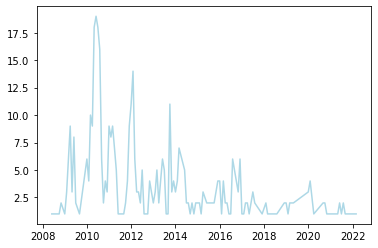

In [13]:
plt.plot(dt_df.groupby('date')['num_lf'].sum(), color = 'lightblue');

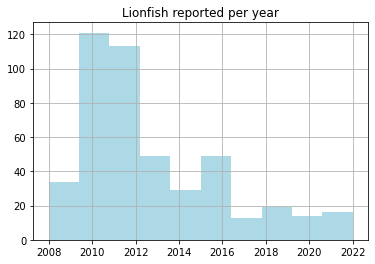

In [14]:
plt.title('Lionfish reported per year')
lf_df.Year.hist(color = 'lightblue', bins = 10);

Significant decline noticed from 2010. The cause is unknown, but significant.

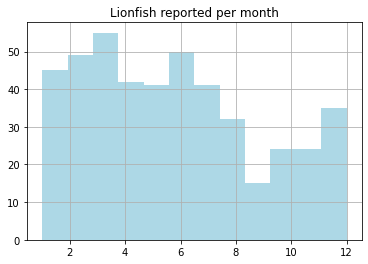

In [15]:
plt.title('Lionfish reported per month')
lf_df.Month.hist(color = 'lightblue', bins = 12);

Decline in reporting observed from September though November. This may be associated with tourist populations.

ref. 3. The best time to visit the U.S. Virgin Islands is April to June, when you can expect mild weather and very little rainfall. In the USVI's peak season, from December to March, the temperature ranges from the mid-70s to high 80s with breezy evenings. July to October is the region's hurricane season with average temps in the upper 80s.

ref. 4. The best times to visit the U.S. Virgin Islands are December through April during the dry season. The warmer months of March and April are even better. But the best times also depend on what visitors plan to do when they get there. Some months are better than others for spending time on the beaches and in the water. The worst times to visit St. Thomas and the U.S. Virgin Islands are September through November. These months fall inside the heart of the Virgin Islands hurricane season, also known as the rainy season.

peak 12-3, 4-6, Hurricane Season 7-10 best 12-4, worst 9-11

The decided seasonal breakdown is a reflection of both references as follows: 12-2, 3-5, 6-8, with 9-11 being the low.

Null Hypothesis: The mean number of lionfish reported is not correlated with seasonal variations in population. 

Alternative Hypotheis: The mean number of lionfish reported is correlated with seasonal tourist patterns.

In [16]:
low_season = len(lf_df.query('Month >= 9 and Month <=11'))/3
mean_lf = len(lf_df)/12
print('The mean number of reported lionfish during the months of September - November is {}' .format(low_season))
print('The mean number of reported lionfish during the year is {:.1f}' .format(mean_lf))

The mean number of reported lionfish during the months of September - November is 21.0
The mean number of reported lionfish during the year is 38.1


In [17]:
season_cnts = []
def seasonal_count(t_df, rands):
    lens = []
    for r in rands:
        lens.append(len(t_df.query('Month == {}' .format(r))))
    season_cnts.append(np.sum(lens)/3)
for i in range(10000):
    temp_df = lf_df[lf_df['Month'].notna()]
    rand_months = np.random.choice([1,2,3,4,5,6,7,8,9,10,11,12], size = 3)
    seasonal_count(temp_df, rand_months)

In [18]:
print(np.mean(season_cnts))
print(np.std(season_cnts))
print(normaltest(season_cnts)[1])

37.70766666666667
6.696162010186631
2.2500588294216116e-28


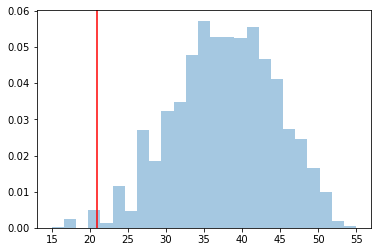

In [19]:
plt.axvline(x = low_season, color = 'r')
sn.distplot(season_cnts, kde=False, norm_hist=True, bins = 25);

In [20]:
1 - np.sum([np.array(season_cnts) > low_season])/10000

0.011900000000000022

Conclusion: With a p-value of .01 the null hypothesis is rejected. There is a correlation between the low season and number of liofish reported.

In [21]:
#total potetial combinations
d_unique = df.DESCRIPTOR.unique()
z_unique = df.ZONE.unique()
h_unique = df.HABITAT.unique()
t_unique = df.TYPE.unique()
print('Total Potential Combinations of Zone, Descriptor, Habitat, and Type: {}'.format(len(d_unique)* len(z_unique)\
                                                                                       * len(h_unique)* len(t_unique)))

Total Potential Combinations of Zone, Descriptor, Habitat, and Type: 19665


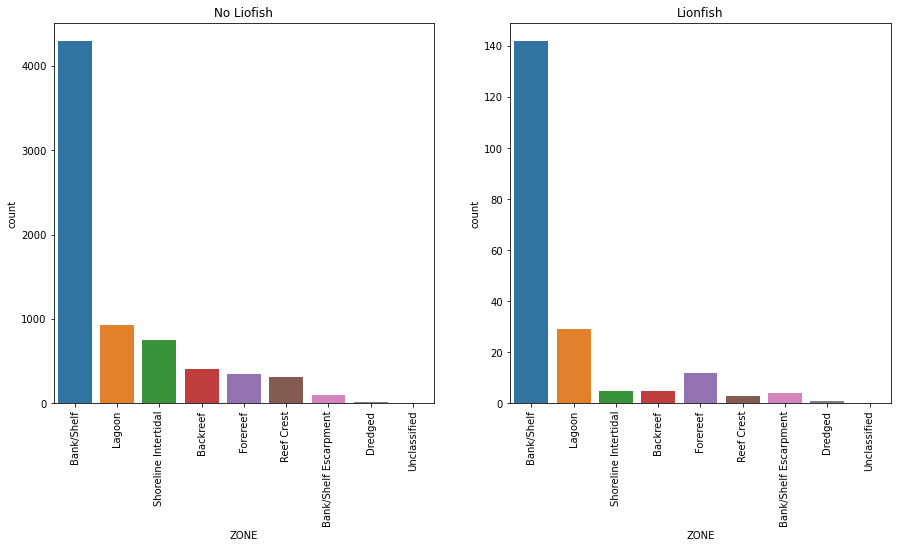

In [22]:
plot_sidebysides(df, 'ZONE')

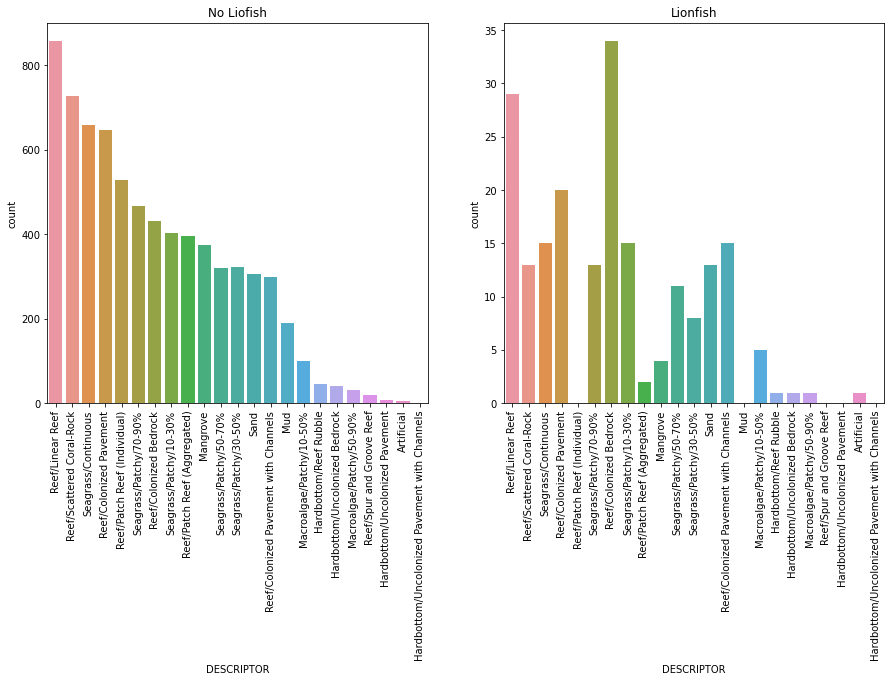

In [23]:
plot_sidebysides(df, 'DESCRIPTOR')

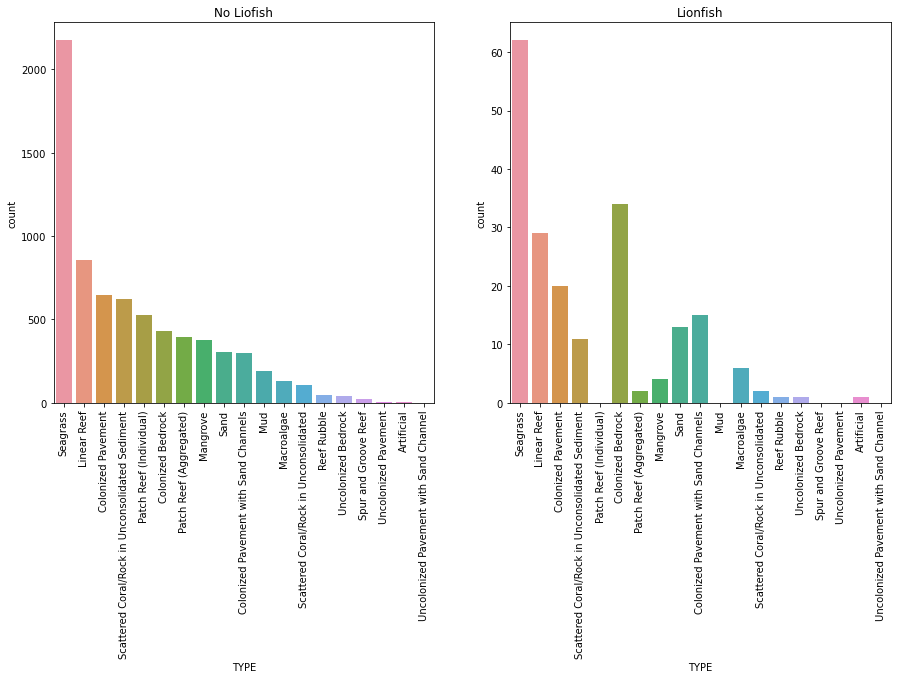

In [24]:
plot_sidebysides(df, 'TYPE')

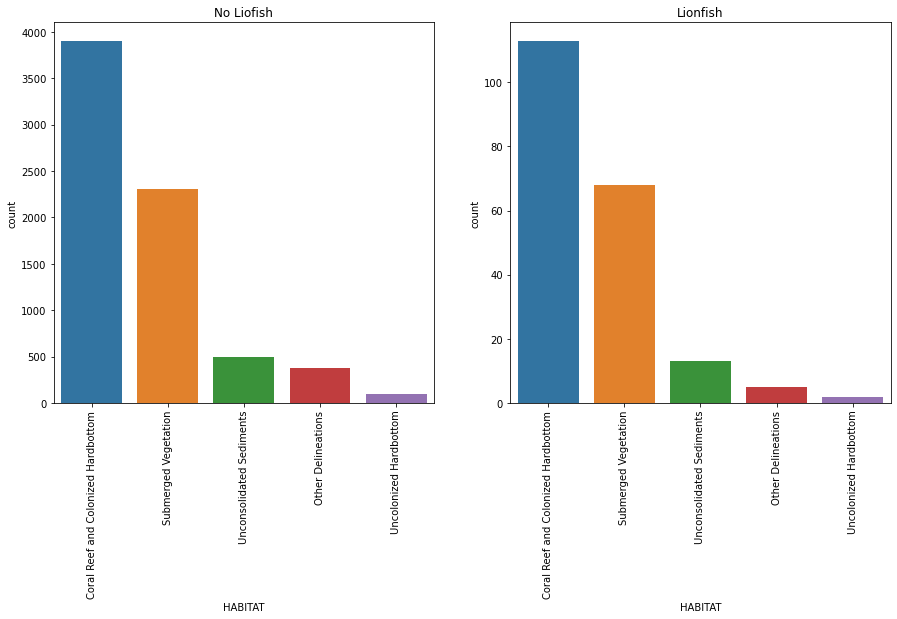

In [25]:
plot_sidebysides(df, 'HABITAT')

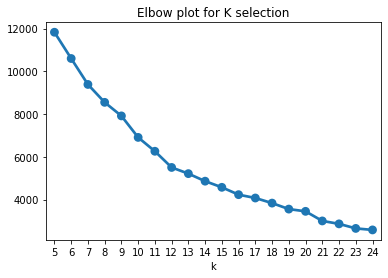

In [26]:
def elbow_plot(data):
    sse = {}
    for k in range(5, 25):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    sn.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()
k_train = pd.get_dummies(df[['DESCRIPTOR', 'ZONE', 'HABITAT', 'TYPE']], drop_first = False)
elbow_plot(k_train)

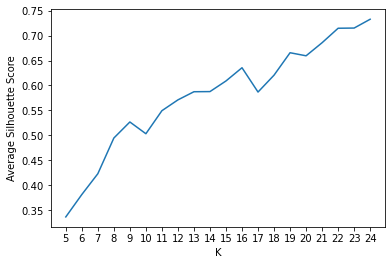

In [27]:
import sklearn.metrics
import matplotlib.cm as cm

avg_silhouette_scores = []
Krange = range(5, 25)
x_cols = k_train
for K in Krange:
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)
    silhouette_avg  = sklearn.metrics.silhouette_score(x_cols, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    sample_silhouette_values = sklearn.metrics.silhouette_samples(x_cols, cluster_labels)
plt.xlabel("K")
plt.ylabel("Average Silhouette Score")
plt.xticks(range(5, 26, 1))
plt.plot(Krange, avg_silhouette_scores);

In [28]:
n_clusters = 21
kmeans = KMeans(n_clusters= n_clusters)
kmeans.fit(k_train)

KMeans(n_clusters=21)

In [29]:
t_clusters = kmeans.predict(k_train)
df['clusters'] = t_clusters

In [30]:
id_df = df[['polyid', 'clusters', 'num_lf']]
gdf = pd.merge(gdf, id_df, on = 'polyid')
gdf.head()

,AREA,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,num_lf
0,6445.33,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_1,"POLYGON ((-64.80970 18.36644, -64.80955 18.366...",9,0
1,47409.30,Sand,Bank/Shelf,Unconsolidated Sediments,Sand,STJ_2,"POLYGON ((-64.80417 18.35974, -64.80419 18.359...",9,0
2,44504.30,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_3,"POLYGON ((-64.81332 18.35635, -64.81342 18.356...",3,0
3,5698.10,Reef/Scattered Coral-Rock,Bank/Shelf,Coral Reef and Colonized Hardbottom,Scattered Coral/Rock in Unconsolidated,STJ_4,"POLYGON ((-64.81626 18.34365, -64.81617 18.344...",3,0
4,24547.68,Reef/Linear Reef,Forereef,Coral Reef and Colonized Hardbottom,Linear Reef,STJ_5,"POLYGON ((-64.79880 18.35579, -64.79875 18.355...",16,0


In [31]:
cluster_prob = []
for c in range(n_clusters):
    cluster_id = c
    cluster_ = gdf.query('clusters == {}' .format(cluster_id))
    lf_w_cluster = gdf.query('num_lf >= 1')
    lf_w_cluster_ = lf_w_cluster.query('clusters == {}' .format(cluster_id))
    p_lf = len(lf_w_cluster)/len(df)
    p_C = len(cluster_)/len(df)
    p_C_lf = len(lf_w_cluster_)/len(lf_w_cluster)
    cluster_prob.append((p_C_lf * p_lf)/ p_C)
    print('Cluster id: {}, Probability: {}' .format(c, (p_C_lf * p_lf)/ p_C))

Cluster id: 0, Probability: 0.0
Cluster id: 1, Probability: 0.07296137339055796
Cluster id: 2, Probability: 0.031007751937984496
Cluster id: 3, Probability: 0.017264276228419653
Cluster id: 4, Probability: 0.01907356948228883
Cluster id: 5, Probability: 0.020661157024793392
Cluster id: 6, Probability: 0.010554089709762533
Cluster id: 7, Probability: 0.02998500749625188
Cluster id: 8, Probability: 0.0
Cluster id: 9, Probability: 0.04075235109717869
Cluster id: 10, Probability: 0.005037783375314861
Cluster id: 11, Probability: 0.04777070063694267
Cluster id: 12, Probability: 0.02619047619047619
Cluster id: 13, Probability: 0.044843049327354265
Cluster id: 14, Probability: 0.02253521126760563
Cluster id: 15, Probability: 0.0392156862745098
Cluster id: 16, Probability: 0.03934426229508197
Cluster id: 17, Probability: 0.043478260869565216
Cluster id: 18, Probability: 0.006024096385542168
Cluster id: 19, Probability: 0.03896103896103897
Cluster id: 20, Probability: 0.029411764705882353


In [32]:
cluster_prob_scaled = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(cluster_prob).reshape(-1,1))

In [33]:
cluster_probs = []
def get_cluster_probs(x):
    cluster_probs.append(cluster_prob_scaled[x][0])
_ = gdf['clusters'].apply(get_cluster_probs)
gdf['rel_probs'] = cluster_probs 

In [34]:
gdf.query('clusters == 12')

,AREA,DESCRIPTOR,ZONE,HABITAT,TYPE,polyid,geometry,clusters,num_lf,rel_probs
7,6897.70,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STJ_9,"POLYGON ((-64.78768 18.34818, -64.78759 18.348...",12,0,0.358964
8,13675.68,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STJ_10,"POLYGON ((-64.79092 18.34283, -64.79092 18.342...",12,0,0.358964
13,4343.57,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STJ_15,"POLYGON ((-64.79954 18.33498, -64.79964 18.334...",12,0,0.358964
31,93155.43,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STJ_35,"POLYGON ((-64.77223 18.35497, -64.77226 18.355...",12,0,0.358964
44,8686.42,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STJ_52,"POLYGON ((-64.79858 18.33521, -64.79862 18.335...",12,0,0.358964
...,...,...,...,...,...,...,...,...,...,...
7268,2569.73,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STC_1066,"POLYGON ((-64.64294 17.76562, -64.64286 17.765...",12,0,0.358964
7269,5655.47,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STC_1067,"POLYGON ((-64.63980 17.76577, -64.63985 17.765...",12,0,0.358964
7356,1590287.21,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STC_1157,"POLYGON ((-64.62151 17.78274, -64.62151 17.782...",12,1,0.358964
7361,1128983.30,Seagrass/Continuous,Bank/Shelf,Submerged Vegetation,Seagrass,STC_1162,"POLYGON ((-64.65698 17.76878, -64.65698 17.768...",12,3,0.358964


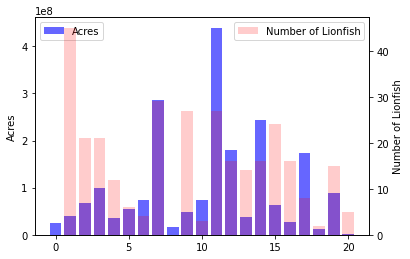

In [35]:
x = range(0,n_clusters)
y = gdf.groupby('clusters')['AREA'].sum().values
y2 = gdf.groupby('clusters')['num_lf'].sum().values
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.bar(x, y, color = 'blue', alpha = .6, label = 'Acres')
ax.set_ylabel('Acres')
ax.legend(loc=2)
ax2 = ax.twinx()
ax2.set_ylabel('Number of Lionfish')
width = 0.4
ax2.bar(x, y2, color = 'red', alpha = .2, label = 'Number of Lionfish')
ax2.legend(loc = 0)
plt.show()

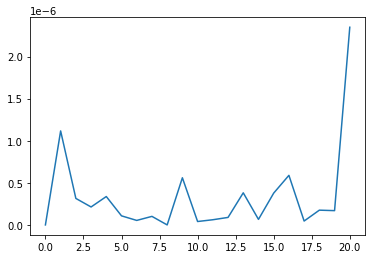

In [36]:
area_lf = {}
for n in range(0, n_clusters):
    t_df = df.query('clusters == {}'.format(n))[['AREA', 'num_lf']].sum()
    area_lf[n] = t_df.num_lf/t_df.AREA# * 10000000
lists = sorted(area_lf.items())
x, y = zip(*lists) 
plt.plot(x, y)
plt.show()

In [37]:
#gdf.to_file('../data/processed/gdf_w_clusters.shp')